# Memory Agent
- Until now, the agents we built,
    * saved all the information
    * saved either to a **profile** schema or to a **collection** schema

# AI Task Manager

- Now, we will build a chatbot that,
    * decides when to save something in the long-term memory
    * decides whether to store the information in the **user_profile** schema or in the **to_do_collection** schema
- That mean, our agent will have **semantic** as well as **procedural** memory

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

## Visibility into Trustcall Updates

In [2]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

### Adding a `listener` to the Trustcall extractor
- This will pass runs from the extractor's execution to a class, `Spy` that we will define
- Our spy class will extract information about what tool calls were made by Trustcall

In [3]:
os.environ['LANGSMITH_TRACING'] = 'false'
from trustcall import create_extractor

# Inspect the tool_calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []
    
    def __call__(self,run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs['generations'][0][0]['message']['kwargs']['tool_calls']
                )
# Initilaize the spy
spy =Spy()

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [4]:
trustcall_extractor_see_all_tool_calls

RunnableBinding(bound=RunnableLambda(coerce_inputs)
| <langgraph.graph.state.CompiledStateGraph object at 0x000001BB798B3F10>
| RunnableLambda(filter_state), config_factories=[<function Runnable.with_listeners.<locals>.<lambda> at 0x000001BB77B95260>])

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Manan."), 
                AIMessage(content="Nice to meet you, Manan."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Kj2z2HPjDUUkKXTUB6Wip2Aa', 'function': {'arguments': '{"content":"Manan had a nice bike ride in San Francisco this morning."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 110, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run-43dae252-b347-4f40-a6a8-6952543b0ea6-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'Manan had a nice bike ride in San Francisco this morning.'}, 'id': 'call_Kj2z2HPjDUUkKXTUB6Wip2Aa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 110, 'output_tokens': 17, 'total_tokens': 127})

In [6]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Manan had a nice bike ride in San Francisco this morning.'})]

In [7]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})
result

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_OI4wMesVOscn7gf1DF6UNfPc': '0'}}, id='1282a927-69ab-4d71-8298-1544e543b2ac', tool_calls=[{'name': 'Memory', 'args': {'content': 'Manan had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant.'}, 'id': 'call_OI4wMesVOscn7gf1DF6UNfPc', 'type': 'tool_call'}, {'name': 'Memory', 'args': {'content': 'Manan was thinking about his trip to Japan and considering going back this winter.'}, 'id': 'call_srwKdFA6bio5Egr1UkH0XOLM', 'type': 'tool_call'}])],
 'responses': [Memory(content='Manan had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant.'),
  Memory(content='Manan was thinking about his trip to Japan and considering going back this winter.')],
 'response_metadata': [{'id': 'call_OI4wMesVOscn7gf1DF6UNfPc',
   'json_doc_id': '0'},
  {'id': 'call_srwKdFA6bio5Egr1UkH0XOLM'}],
 'attempts': 1}

In [8]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_OI4wMesVOscn7gf1DF6UNfPc', 'json_doc_id': '0'}
{'id': 'call_srwKdFA6bio5Egr1UkH0XOLM'}


In [9]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_OI4wMesVOscn7gf1DF6UNfPc)
 Call ID: call_OI4wMesVOscn7gf1DF6UNfPc
  Args:
    content: Manan had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant.
  Memory (call_srwKdFA6bio5Egr1UkH0XOLM)
 Call ID: call_srwKdFA6bio5Egr1UkH0XOLM
  Args:
    content: Manan was thinking about his trip to Japan and considering going back this winter.


In [10]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='Manan had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant.'
content='Manan was thinking about his trip to Japan and considering going back this winter.'


In [11]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add the new memory about going to Tartine and eating a croissant after the bike ride. This involves appending a new sentence to the existing content field in the Memory schema.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Manan had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant.'}]},
   'id': 'call_OI4wMesVOscn7gf1DF6UNfPc',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Manan was thinking about his trip to Japan and considering going back this winter.'},
   'id': 'call_srwKdFA6bio5Egr1UkH0XOLM',
   'type': 'tool_call'}]]

In [12]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Add the new memory about going to Tartine and eating a croissant after the bike ride. This involves appending a new sentence to the existing content field in the Memory schema.
Added content: Manan had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant.

New Memory created:
Content: {'content': 'Manan was thinking about his trip to Japan and considering going back this winter.'}


## Building an Agent
- We will build a sort of `ReAct` agent.

Our agent will have three types of memory:
- `Profile`: Create or update a user profile
- `Collection`: Add or Update elements to a To-Do List
- `Instructions` about how to create/updates To-Do Elements 

In [37]:
# For structured output from the agent about which memory to update, let's create a class
from typing import TypedDict, Literal

class UpdateMemory(TypedDict):
    """Decision about which memory to update"""
    update_type: Literal["user", "todo", "instructions"]

### Graph Definition
- We use a `binary router` to decide whether to update/create memory or not
- We deal with memory in the `write_memory` node like before

In [19]:
# Defining the Profile and ToDo Schemas 
from pydantic import BaseModel, Field
from typing import Optional, List, Literal
from datetime import datetime

class Profile(BaseModel):
    """"User Profile schema"""
    name: Optional[str] = Field(description="The name of the user")
    location: Optional[str] = Field(description="The location of the user")
    job_title: Optional[str] = Field(description="The job title of the user")
    # The default_factory=list means that if no value is provided for 'connections', it will default to an empty list.
    connections: List[str] = Field(description="The list of connections of the user", default_factory=list)
    interests: List[str] = Field(description="The list of interests of the user", default_factory=list)

class ToDo(BaseModel):
    """A collection of To-Do items containing information about the task"""
    task: str = Field(description="The task to be completed")
    time_to_complete: Optional[int] = Field(description="The time to complete the task")
    deadline: Optional[datetime] = Field(description="The deadline of the task", default=None)
    solutions: list[str] = Field(description="The solutions to the task", min_items=1, default_factory=list)
    status: Literal["not started", "in progress", "done", "archived"] = Field(description="The status of the task", default="not started")

### Master Node

In [64]:
# This takes in the user input, profile, todo and instructions and decides whether and which tool to call
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.store.memory import InMemoryStore, BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

# Main Prompt
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Node Definition
def task_mAIstro(state: MessagesState, store: BaseStore, config: RunnableConfig):
    # Get the memories from the store
    user_id = config['configurable']['user_id']
    
    # Get the profile
    namespace = ('profile',user_id)
    memories = store.search(namespace)
    ## Format the memories
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None
    
    # Get the ToDo Items
    namespace = ('todo', user_id)
    memories = store.search(namespace)
    todo = '\n'.join(f"{item.value}" for item in memories)
    
    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

### Node 1: For Updating User Profile

In [52]:
from trustcall import create_extractor
from langchain_core.messages import merge_message_runs
import uuid

# Trustcall Extractor for updating the profile
profile_extractor = create_extractor(model,
                                       tools=[Profile],
                                       tool_choice="Profile")

# Prompt for updating the user_profile
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Create a function that extracts memories, invokes trustcall to get the patches and updates the memories
def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the memory for the prompt
    tool_name = 'Profile'
    existing_memories = ([(item.key, tool_name, item.value) for item in existing_items] if existing_items else None)

    # Format the prompt and call the extractor
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})
    
    # Update the Profile
    for r, r_meta in zip(result['responses'], result['response_metadata']):
        store.put(namespace, key = r_meta.get('json_doc_id', str(uuid.uuid4())), value = r.model_dump(mode='json'))
    
    # We must return a confirmation to the llm that a tool_call has been made successfully, if any
    tool_calls = state['messages'][-1].tool_calls

    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

### Node 2: For Updating ToDo Collection

In [47]:
def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to Main Node
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

### Node 3: For Updating Instructions

In [48]:
# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

### Conditional Edge: Routing Function

In [49]:
# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

### Build the Graph

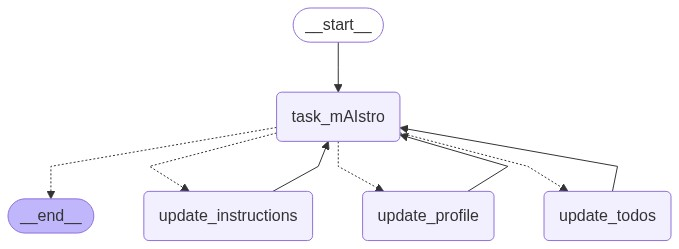

In [65]:
from IPython.display import display, Image
# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node("update_todos",update_todos)
builder.add_node("update_profile",update_profile)
builder.add_node("update_instructions",update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Sample Runs

In [66]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Manan"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Manan. I am a student at IIT-Kharagpur. I love Coding!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Manan. I am a student at IIT-Kharagpur. I love Coding!
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6Wy7Rf5oj6gchmTPswvNCodM)
 Call ID: call_6Wy7Rf5oj6gchmTPswvNCodM
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Nice to meet you, Manan! It's great to hear that you're a student at IIT-Kharagpur and that you love coding. How can I assist you today?


In [67]:
# User input for a ToDo
input_messages = [HumanMessage(content="I want to finish the 'Introduction_to_Langgraph Course!'")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I want to finish the 'Introduction_to_Langgraph Course!'
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_SH15PDEHdaCZVytMiaHa4zZQ)
 Call ID: call_SH15PDEHdaCZVytMiaHa4zZQ
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': "Finish the 'Introduction_to_Langgraph Course'", 'time_to_complete': 5, 'deadline': None, 'solutions': ['Set aside dedicated study time each day', 'Review course materials and take notes', 'Complete all assignments and quizzes', 'Join study groups or forums for discussion'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Finish the 'Introduction_to_Langgraph Course'" to your ToDo list. If you need any help or strategies to complete it, feel free to ask!


In [68]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, make sure to include a motivational quote!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, make sure to include a motivational quote!
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_SkbavUOYMqLAnk9mwWYHJnyI)
 Call ID: call_SkbavUOYMqLAnk9mwWYHJnyI
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include a motivational quote whenever I create or update your ToDo items. If there's anything else you need, just let me know!


In [69]:
# Check for updated instructions
user_id = "Manan"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': '<current_instructions>\nWhen creating or updating ToDo list items, include a motivational quote to inspire and encourage the user.\n</current_instructions>'}


In [70]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to learn basic DSA, SQL for my interviews :( )")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to learn basic DSA, SQL for my interviews :( )
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_5jhH2AaFIT6vRCYGF0nxoea1)
 Call ID: call_5jhH2AaFIT6vRCYGF0nxoea1
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Learn basic DSA for interviews', 'time_to_complete': 10, 'solutions': ['Set a study schedule', 'Use online resources and tutorials', 'Practice coding problems', 'Join study groups'], 'status': 'not started'}

New ToDo created:
Content: {'task': 'Learn basic SQL for interviews', 'time_to_complete': 8, 'solutions': ['Follow a structured course', 'Practice with real databases', 'Work on SQL projects', 'Review SQL interview questions'], 'status': 'not started'}
================================== Ai Message ===========================

In [72]:
# Namespace for the memory to save
user_id = "Manan"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print("-"*50)
    print(memory.value)

--------------------------------------------------
{'task': "Finish the 'Introduction_to_Langgraph Course'", 'time_to_complete': 5, 'deadline': None, 'solutions': ['Set aside dedicated study time each day', 'Review course materials and take notes', 'Complete all assignments and quizzes', 'Join study groups or forums for discussion'], 'status': 'not started'}
--------------------------------------------------
{'task': 'Learn basic DSA for interviews', 'time_to_complete': 10, 'deadline': None, 'solutions': ['Set a study schedule', 'Use online resources and tutorials', 'Practice coding problems', 'Join study groups'], 'status': 'not started'}
--------------------------------------------------
{'task': 'Learn basic SQL for interviews', 'time_to_complete': 8, 'deadline': None, 'solutions': ['Follow a structured course', 'Practice with real databases', 'Work on SQL projects', 'Review SQL interview questions'], 'status': 'not started'}


In [73]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the langgraph lessons, I need to get that done by the first week of July!.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the langgraph lessons, I need to get that done by the first week of July!.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_DTxQp4PLANyJoV3yDfF8xYD9)
 Call ID: call_DTxQp4PLANyJoV3yDfF8xYD9
  Args:
    update_type: todo
================================= Tool Message =================================

Document be2a67e9-14e3-4d72-897d-5aa2a3f5bd6e updated:
Plan: 1. Add a deadline to the task 'Finish the Introduction_to_Langgraph Course' with the date set to the end of the first week of July 2025. This involves updating the 'deadline' field.
2. Add a motivational quote to the task to inspire the user to complete it.
Added content: 2025-07-07T23:59:59
================================== Ai Message ==================================

I've updated your ToDo list with a deadline for the "Introduction_to_Langgraph Course" to be completed by the f

## Trying with a New Thread
- All the long-term memories are retained!

In [74]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Manan"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

Let's take a look at your current ToDo list to see what tasks might fit into a 30-minute window:

1. **Finish the 'Introduction_to_Langgraph Course'** - Estimated time: 5 hours
2. **Learn basic DSA for interviews** - Estimated time: 10 hours
3. **Learn basic SQL for interviews** - Estimated time: 8 hours

While none of these tasks can be fully completed in 30 minutes, you can make progress on any of them. Here are some suggestions:

- **Introduction_to_Langgraph Course**: Spend 30 minutes reviewing course materials or taking notes.
- **Learn basic DSA**: Use the time to practice a few coding problems or watch a short tutorial.
- **Learn basic SQL**: You could follow a short lesson or practice a few SQL queries.

Remember, every small step counts! Let me know if you'd like to add 

In [75]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Thanks! Let's start learning SQL. Give me something to start.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks! Let's start learning SQL. Give me something to start.
================================== Ai Message ==================================

Great choice! Here's a simple plan to get you started with SQL in your 30-minute session:

1. **Follow a Structured Course**: Begin with a basic tutorial or course. Websites like W3Schools or Codecademy offer free introductory lessons on SQL. You can start with understanding the basic SQL syntax and commands like `SELECT`, `FROM`, and `WHERE`.

2. **Practice with Real Databases**: If you have access to a database, try running some basic queries. If not, you can use online platforms like SQLFiddle or DB-Fiddle to practice.

3. **Work on SQL Projects**: Consider starting a small project, like creating a simple database for a personal project or hobby. This will help you apply what you learn.

4. **Review SQL Interview Questions**: If you're preparing for interviews,